In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Path

In [2]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'

# Data

In [3]:
# CMAP drugs
compound_info = pd.read_csv(poseidon_home + '/data/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
1-EBIO,BRD-K70586315,NaN,NaN,CCn1c2ccccc2[nH]c1=O,CXUCKELNYMZTRT-UHFFFAOYSA-N,NaN
1-HYDROXYANTHRAQUINONE,BRD-K62620932,NaN,NaN,NaN,NaN,NaN
1-HYDROXYPHENAZINE,BRD-K66151076,NaN,NaN,NaN,NaN,NaN
1-NAPHTHYLAMINE,BRD-K05741221,NaN,NaN,NaN,NaN,NaN
1-NITRONAPHTHALENE,BRD-K72839221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
zolpidem,BRD-K44876623,GABRA1,Benzodiazepine receptor agonist,CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,NaN
zonisamide,BRD-A28095882,SCN11A,Sodium channel blocker,CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N,KZFDKINRISJFCO-UHFFFAOYSA-N,NaN
zopiclone,BRD-A34309505,GABRA1,GABA receptor agonist,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,GBBSUAFBMRNDJC-UHFFFAOYSA-N,NaN


In [4]:
cmap_drug = list(compound_info.index.unique())

In [63]:
skcm_sig_info = pd.read_csv(poseidon_home + '/data/CMAP2020_Cancer/SKCM/skcm_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [5]:
# GDSC original tables
gdsc_ori1 = pd.read_csv(poseidon_home + 'data/GDSC/GDSC1_fitted_dose_response_25Feb20.csv',
                        header=0, index_col=0, sep=',')

gdsc_ori2 = pd.read_csv(poseidon_home + 'data/GDSC/GDSC2_fitted_dose_response_25Feb20.csv',
                        header=0, index_col=0, sep=',')

In [4]:
gdsc_ori1

,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
DATASET,,,,,,,,,,,,,,,,,,
GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.395685,0.982114,0.022521,-0.189576
GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.140923,0.984816,0.031840,0.508635
GDSC1,281,12975647,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.968757,0.985693,0.026052,1.284229
GDSC1,281,12975980,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.692768,0.972699,0.110056,0.088760
GDSC1,281,12976330,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.478678,0.944462,0.087011,-0.111820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GDSC1,281,13269726,1660034,SNU-407,SIDM00214,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,4.820567,0.975376,0.032752,0.299720
GDSC1,281,13269986,1660035,SNU-61,SIDM00194,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.785978,0.977001,0.040082,1.742423
GDSC1,281,13270253,1660036,SNU-81,SIDM00193,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.393454,0.979140,0.042595,1.155838


In [5]:
gdsc_ori2

,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
DATASET,,,,,,,,,,,,,,,,,,
GDSC2,282,13320532,749709,HCC1954,SIDM00872,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-0.251083,0.975203,0.112373,0.906631
GDSC2,282,13320565,749710,HCC1143,SIDM00866,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,1.343315,0.978464,0.067577,1.683567
GDSC2,282,13320598,749711,HCC1187,SIDM00885,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,1.736985,0.995100,0.045205,1.875399
GDSC2,282,13320631,749712,HCC1395,SIDM00884,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-2.309078,0.867832,0.107282,-0.096212
GDSC2,282,13320668,749713,HCC1599,SIDM00877,BRCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-3.106684,0.777532,0.098286,-0.484878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GDSC2,282,13322622,1290798,EFM-192A,SIDM01002,BRCA,2172,JQ1,"BRD2, BRD3, BRD4, BRDT",Chromatin other,1046,Y,0.009766,10.0,3.576583,0.931696,0.113045,0.408803
GDSC2,282,13322655,1290905,HCC1428,SIDM00881,BRCA,2172,JQ1,"BRD2, BRD3, BRD4, BRDT",Chromatin other,1046,Y,0.009766,10.0,1.402466,0.738310,0.076166,-0.842127
GDSC2,282,13322694,1290922,HDQ-P1,SIDM01062,BRCA,2172,JQ1,"BRD2, BRD3, BRD4, BRDT",Chromatin other,1046,Y,0.009766,10.0,2.762460,0.890749,0.118497,-0.059622


In [6]:
# drug numbers
print(gdsc_ori1['DRUG_NAME'].unique().shape)
print(gdsc_ori2['DRUG_NAME'].unique().shape)

(345,)
(192,)


In [7]:
gdsc_ori1_drug = list(gdsc_ori1['DRUG_NAME'].unique())
gdsc_ori2_drug = list(gdsc_ori2['DRUG_NAME'].unique())

In [8]:
len(set(gdsc_ori1_drug) | set(gdsc_ori2_drug))

449

# Overlap

## 1. naive pair

In [9]:
len(cmap_drug)

33627

In [10]:
len(gdsc_ori1_drug)

345

In [11]:
len(gdsc_ori2_drug)

192

In [12]:
op1_naive = set(cmap_drug) & set(gdsc_ori1_drug)
op2_naive = set(cmap_drug) & set(gdsc_ori2_drug)

In [21]:
len(op1_naive)

62

In [22]:
len(op2_naive)

20

## 2. capital removal 

In [13]:
gdsc_oril1_drug_lower = [i.lower() for i in gdsc_ori1_drug]

In [14]:
gdsc_oril2_drug_lower = [i.lower() for i in gdsc_ori2_drug]

In [15]:
op1_caprm = set(cmap_drug) & set(gdsc_oril1_drug_lower)
op2_caprm = set(cmap_drug) & set(gdsc_oril2_drug_lower)

In [16]:
len(op1_caprm)

94

In [17]:
len(op2_caprm)

61

In [18]:
len(set(op2_caprm) & set(op1_caprm))

38

## 3. merge the overlaps

In [19]:
merge_cmap_op = set(op1_naive) | set(op2_naive) | set(op1_caprm) | set(op2_caprm)

In [20]:
len(merge_cmap_op)

188

In [21]:
cmap_gdsc = df(index=merge_cmap_op, columns=['GDSC_name', 'GDSC_V1', 'GDSC_V2'])
for d in cmap_gdsc.index:
    if d in op1_naive:
        cmap_gdsc.at[d, 'GDSC_name'] = d
        cmap_gdsc.at[d, 'GDSC_V1'] = 'Yes'
    if d in op2_naive:
        cmap_gdsc.at[d, 'GDSC_name'] = d
        cmap_gdsc.at[d, 'GDSC_V2'] = 'Yes'
    if d in op1_caprm:
        cmap_gdsc.at[d, 'GDSC_name'] = d.capitalize()
        cmap_gdsc.at[d, 'GDSC_V1'] = 'Yes'
    if d in op2_caprm:
        cmap_gdsc.at[d, 'GDSC_name'] = d.capitalize()
        cmap_gdsc.at[d, 'GDSC_V2'] = 'Yes'
cmap_gdsc = cmap_gdsc.fillna('No')

In [57]:
cmap_gdsc

,GDSC_name,GDSC_V1,GDSC_V2
KIN001-260,KIN001-260,Yes,No
refametinib,Refametinib,Yes,No
navitoclax,Navitoclax,Yes,Yes
elesclomol,Elesclomol,Yes,No
voxtalisib,Voxtalisib,Yes,No
...,...,...,...
CX-5461,CX-5461,Yes,No
bicalutamide,Bicalutamide,Yes,No
bosutinib,Bosutinib,Yes,No
lapatinib,Lapatinib,Yes,Yes


In [59]:
cmap_gdsc['GDSC_V1'].value_counts()

Yes    156
No      32
Name: GDSC_V1, dtype: int64

In [60]:
cmap_gdsc['GDSC_V2'].value_counts()

No     107
Yes     81
Name: GDSC_V2, dtype: int64

In [61]:
cmap_gdsc.to_csv(poseidon_home + 'data/GDSC/CMAP2020_to_GDSC_name.csv', sep=',')

# SKCM only subset

In [62]:
gdsc_ori1_skcm = gdsc_ori1[gdsc_ori1['TCGA_DESC'] == 'SKCM']['DRUG_NAME'].unique()
gdsc_ori2_skcm = gdsc_ori2[gdsc_ori2['TCGA_DESC'] == 'SKCM']['DRUG_NAME'].unique()

In [64]:
cmap_skcm = skcm_sig_info['cmap_name'].unique()

In [67]:
cmap_gdsc_skcm = cmap_gdsc[cmap_gdsc.index.isin(cmap_skcm)]
cmap_gdsc_skcm = cmap_gdsc_skcm[cmap_gdsc_skcm['GDSC_name'].isin(set(gdsc_ori1_skcm) | set(gdsc_ori2_skcm))]

In [69]:
cmap_gdsc_skcm.to_csv(poseidon_home + 'data/GDSC/CMAP2020_to_GDSC_name_SKCM_only.csv', sep=',')

In [70]:
cmap_gdsc_skcm.shape

(119, 3)

# Drug response subset

In [71]:
gdsc_subset1 = gdsc_ori1[gdsc_ori1['TCGA_DESC'] == 'SKCM']
gdsc_subset1 = gdsc_subset1[gdsc_subset1['DRUG_NAME'].isin(cmap_gdsc_skcm['GDSC_name'])]

gdsc_subset2 = gdsc_ori2[gdsc_ori2['TCGA_DESC'] == 'SKCM']
gdsc_subset2 = gdsc_subset2[gdsc_subset2['DRUG_NAME'].isin(cmap_gdsc_skcm['GDSC_name'])]

In [74]:
gdsc_subset1.to_csv(poseidon_home + 'data/GDSC/GDSC1_response_subset_CMAP_SKCM.csv', sep=',')
gdsc_subset2.to_csv(poseidon_home + 'data/GDSC/GDSC2_response_subset_CMAP_SKCM.csv', sep=',')

In [225]:
# A375
gdsc_subset1_A375 = gdsc_subset1[gdsc_subset1['CELL_LINE_NAME'] == 'A375']
gdsc_subset2_A375 = gdsc_subset2[gdsc_subset2['CELL_LINE_NAME'] == 'A375']

In [79]:
gdsc_subset1_A375.to_csv(poseidon_home + 'data/GDSC/GDSC1_response_subset_CMAP_A375.csv', sep=',')
gdsc_subset2_A375.to_csv(poseidon_home + 'data/GDSC/GDSC2_response_subset_CMAP_A375.csv', sep=',')

In [219]:
gdsc_subset1['CELL_LINE_NAME'].unique()

array(['COLO-829', 'CP66-MEL', 'LB2518-MEL', 'LB373-MEL-D', 'MZ7-mel',
       'SK-MEL-2', 'LOXIMVI', 'UACC-257', 'COLO-800', 'HT-144',
       'IST-MEL1', 'SH-4', 'SK-MEL-1', 'A101D', 'MMAc-SF', 'MZ2-MEL',
       'GAK', 'CP67-MEL', 'CP50-MEL-B', 'SK-MEL-28', 'SK-MEL-5', 'M14',
       'UACC-62', 'A2058', 'A375', 'COLO-792', 'COLO-679', 'C32', 'G-361',
       'HMV-II', 'IGR-1', 'IPC-298', 'MEL-JUSO', 'Mewo', 'RVH-421',
       'SK-MEL-3', 'SK-MEL-24', 'SK-MEL-30', 'CHL-1', 'RPMI-7951',
       'VMRC-MELG', 'COLO-783', 'G-MEL', 'IGR-37', 'WM278', '451Lu',
       'Hs-939-T', 'Hs-940-T', 'K2', 'WM1552C', 'WM35', 'WM793B',
       'WM-115', 'MEL-HO', 'SK-MEL-31'], dtype=object)

In [220]:
gdsc_subset2['CELL_LINE_NAME'].unique()

array(['COLO-829', 'CP66-MEL', 'SK-MEL-2', 'SK-MEL-5', 'LOXIMVI', 'M14',
       'UACC-62', 'UACC-257', 'A2058', 'A375', 'COLO-792', 'COLO-679',
       'C32', 'G-361', 'HMV-II', 'HT-144', 'IGR-1', 'IST-MEL1',
       'MEL-JUSO', 'Mewo', 'SH-4', 'SK-MEL-1', 'SK-MEL-24', 'WM-115',
       'CHL-1', 'RPMI-7951', 'A101D', 'GAK', 'G-MEL', 'IGR-37', 'WM278',
       'WM1552C', 'WM35', 'WM793B'], dtype=object)

In [223]:
shift_ability['cell_line'].value_counts()

A375       4728
SKMEL5      169
SKMEL28      13
SKMEL1        7
Name: cell_line, dtype: int64

In [226]:
# SKMEL5
gdsc_subset1_SKM5 = gdsc_subset1[gdsc_subset1['CELL_LINE_NAME'] == 'SK-MEL-5']
gdsc_subset2_SKM5 = gdsc_subset2[gdsc_subset2['CELL_LINE_NAME'] == 'SK-MEL-5']

In [227]:
gdsc_subset1_SKM5.to_csv(poseidon_home + 'data/GDSC/GDSC1_response_subset_CMAP_SKMEL5.csv', sep=',')
gdsc_subset2_SKM5.to_csv(poseidon_home + 'data/GDSC/GDSC2_response_subset_CMAP_SKMEL5.csv', sep=',')

# Include all cell lines and cancer types

In [22]:
gdsc_all1 = gdsc_ori1[gdsc_ori1['DRUG_NAME'].isin(cmap_gdsc['GDSC_name'])]
gdsc_all2 = gdsc_ori2[gdsc_ori2['DRUG_NAME'].isin(cmap_gdsc['GDSC_name'])]

In [23]:
gdsc_all1.shape

(135824, 18)

In [24]:
gdsc_all2.shape

(56094, 18)

In [26]:
gdsc_all1.to_csv(poseidon_home + 'data/GDSC/GDSC1_response_subset_CMAP_all.csv', sep=',')
gdsc_all2.to_csv(poseidon_home + 'data/GDSC/GDSC2_response_subset_CMAP_all.csv', sep=',')

# A375: distribution of drug response

## 1. IC50 and AUCs

### 1.1 GDSC V1

In [80]:
gdsc_subset1_A375.columns

Index(['NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID', 'CELL_LINE_NAME',
       'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME',
       'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID', 'WEBRELEASE',
       'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE', 'Z_SCORE'],
      dtype='object')

In [81]:
gdsc_subset1_A375.shape

(88, 18)

In [82]:
gdsc_subset1_A375['DRUG_NAME'].unique().shape

(80,)

In [83]:
gdsc_subset1_A375['DRUG_ID'].unique().shape

(88,)

In [208]:
len(set(gdsc_subset1_A375['DRUG_NAME'].unique()) | set(gdsc_subset2_A375['DRUG_NAME'].unique()))

107

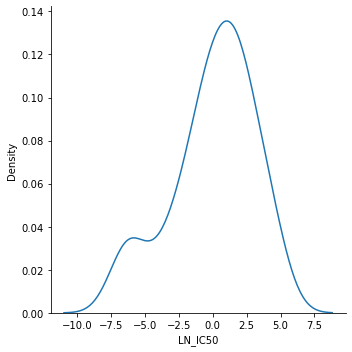

In [85]:
sns.displot(gdsc_subset1_A375['LN_IC50'], kind='kde')

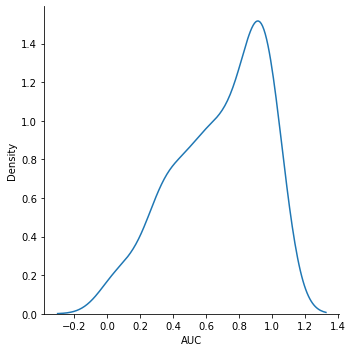

In [86]:
sns.displot(gdsc_subset1_A375['AUC'], kind='kde')

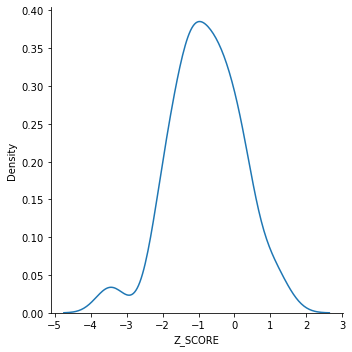

In [87]:
sns.displot(gdsc_subset1_A375['Z_SCORE'], kind='kde')

### 1.2 GDSC V2

In [88]:
gdsc_subset2_A375.columns

Index(['NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID', 'CELL_LINE_NAME',
       'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME',
       'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID', 'WEBRELEASE',
       'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE', 'Z_SCORE'],
      dtype='object')

In [89]:
gdsc_subset2_A375.shape

(53, 18)

In [90]:
gdsc_subset2_A375['DRUG_NAME'].unique().shape

(51,)

In [91]:
gdsc_subset2_A375['DRUG_ID'].unique().shape

(53,)

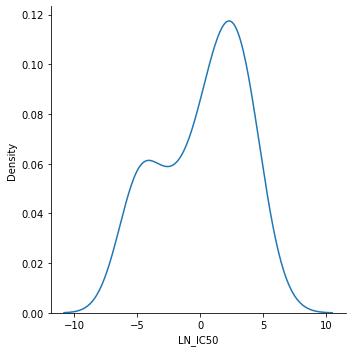

In [92]:
sns.displot(gdsc_subset2_A375['LN_IC50'], kind='kde')

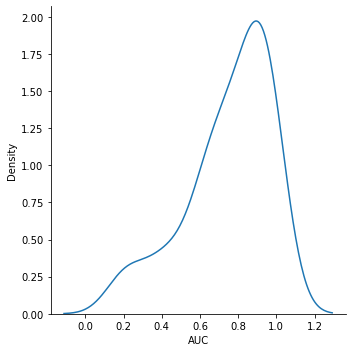

In [93]:
sns.displot(gdsc_subset2_A375['AUC'], kind='kde')

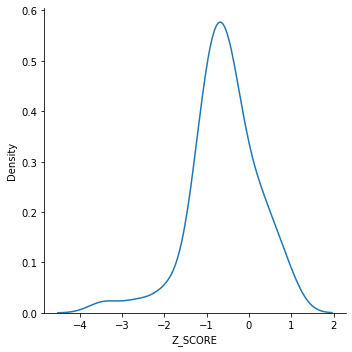

In [94]:
sns.displot(gdsc_subset2_A375['Z_SCORE'], kind='kde')

## 2. MOA counts

In [95]:
gdsc_subset1_A375['PATHWAY_NAME'].value_counts()

Other, kinases                       11
RTK signaling                        11
Other                                 8
ERK MAPK signaling                    8
DNA replication                       7
Chromatin histone acetylation         5
Protein stability and degradation     4
PI3K/MTOR signaling                   4
EGFR signaling                        4
Cell cycle                            4
Genome integrity                      4
Apoptosis regulation                  3
Mitosis                               3
JNK and p38 signaling                 3
Cytoskeleton                          2
IGF1R signaling                       2
Hormone-related                       1
ABL signaling                         1
p53 pathway                           1
WNT signaling                         1
Chromatin other                       1
Name: PATHWAY_NAME, dtype: int64

In [97]:
gdsc_subset1_A375['PUTATIVE_TARGET'].value_counts()

MEK1, MEK2       5
HSP90            4
BRAF             3
PARP1, PARP2     3
Anthracycline    2
                ..
CDK9             1
SERCA            1
ALK              1
EPHB4            1
XIAP             1
Name: PUTATIVE_TARGET, Length: 70, dtype: int64

In [96]:
gdsc_subset2_A375['PATHWAY_NAME'].value_counts()

DNA replication                      7
Mitosis                              5
Other                                4
RTK signaling                        4
ERK MAPK signaling                   4
EGFR signaling                       4
PI3K/MTOR signaling                  3
Cell cycle                           3
IGF1R signaling                      3
Other, kinases                       3
Genome integrity                     3
Protein stability and degradation    2
Chromatin other                      2
Chromatin histone acetylation        2
Unclassified                         1
Hormone-related                      1
Apoptosis regulation                 1
ABL signaling                        1
Name: PATHWAY_NAME, dtype: int64

In [98]:
gdsc_subset2_A375['PUTATIVE_TARGET'].value_counts()

Microtubule stabiliser                                  3
MEK1, MEK2                                              2
BRAF                                                    2
IGF1R                                                   2
EGFR                                                    2
PARP1, PARP2                                            2
TOP1                                                    2
CDK1, CDK2, CDK5, CDK9                                  1
BRD2, BRD3, BRD4                                        1
Proteasome, CAPN1                                       1
Microtubule destabiliser                                1
ERBB2, EGFR                                             1
EGFR, ERBB2                                             1
AKT1, AKT2                                              1
ABL, SRC, Ephrins, PDGFR, KIT                           1
IGF1R, IR                                               1
BRD9                                                    1
TERT          

In [103]:
gdsc_subset1_A375[gdsc_subset1_A375['PUTATIVE_TARGET'] == 'MEK1, MEK2']

,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
DATASET,,,,,,,,,,,,,,,,,,
GDSC1,281,13046993,906793,A375,SIDM00795,SKCM,1014,Refametinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.019531,5.0,-2.046906,0.354169,0.079787,-2.003339
GDSC1,281,13047026,906793,A375,SIDM00795,SKCM,1062,Selumetinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.015625,4.0,2.917618,0.976894,0.049200,0.299527
GDSC1,281,13047072,906793,A375,SIDM00795,SKCM,1372,Trametinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.003906,1.0,-6.692559,0.034941,0.098901,-2.049241
GDSC1,281,13047121,906793,A375,SIDM00795,SKCM,1498,Selumetinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.015625,4.0,-2.576204,0.305881,0.098141,-2.199337
GDSC1,281,13047126,906793,A375,SIDM00795,SKCM,1526,Refametinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.019531,5.0,-2.024891,0.357706,0.080891,-2.036234


In [104]:
gdsc_subset2_A375[gdsc_subset2_A375['PUTATIVE_TARGET'] == 'MEK1, MEK2']

,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
DATASET,,,,,,,,,,,,,,,,,,
GDSC2,282,13346491,906793,A375,SIDM00795,SKCM,1372,Trametinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.001001,1.0,-5.204961,0.285278,0.242665,-1.985205
GDSC2,282,13428259,906793,A375,SIDM00795,SKCM,1736,Selumetinib,"MEK1, MEK2",ERK MAPK signaling,1001,Y,0.010005,10.0,-0.100861,0.629662,0.156526,-1.817401


# Shift ability from CMAP2020 SKCM sets

In [105]:
shift_ability = pd.read_csv(poseidon_home + 'data/shift_ability/merged_shift_compound.csv',
                            header=0, index_col=0, sep=',')

In [106]:
shift_ability

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color
PBIOA018_A375_24H:A23,-0.510429,0.368917,trametinib,-0.879347,0.125,24.0,A375,low,royalblue
REP.B021_A375_24H:E13,-0.508522,0.481902,MEK-162,-0.990424,2.220,24.0,A375,low,royalblue
REP.A019_A375_24H:M23,-0.508466,0.379047,PD-0325901,-0.887513,0.125,24.0,A375,low,royalblue
PBIOA018_A375_24H:A24,-0.503196,0.495135,trametinib,-0.998331,0.040,24.0,A375,low,royalblue
EMU001_SKMEL5_24H:G20,-0.496531,0.400384,auranofin,-0.896915,2.500,24.0,SKMEL5,low,royalblue
...,...,...,...,...,...,...,...,...,...
REP.A004_A375_24H:I22,0.317422,-0.268329,CYT-997,0.585751,0.370,24.0,A375,low,royalblue
MOAR005_A375_24H:L03,0.322656,-0.380208,GMX-1778,0.702864,1.110,24.0,A375,low,royalblue
REP.A022_A375_24H:K24,0.323002,-0.403971,MLN-4924,0.726973,0.040,24.0,A375,low,royalblue
REP.A004_A375_24H:I21,0.324637,-0.393004,CYT-997,0.717642,1.110,24.0,A375,low,royalblue


In [107]:
# add ln concentration
shift_ability['LN_dose'] = np.log(shift_ability['dose'])

In [108]:
np.log(2.71828)

0.999999327347282

In [109]:
shift_ability

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose
PBIOA018_A375_24H:A23,-0.510429,0.368917,trametinib,-0.879347,0.125,24.0,A375,low,royalblue,-2.079442
REP.B021_A375_24H:E13,-0.508522,0.481902,MEK-162,-0.990424,2.220,24.0,A375,low,royalblue,0.797507
REP.A019_A375_24H:M23,-0.508466,0.379047,PD-0325901,-0.887513,0.125,24.0,A375,low,royalblue,-2.079442
PBIOA018_A375_24H:A24,-0.503196,0.495135,trametinib,-0.998331,0.040,24.0,A375,low,royalblue,-3.218876
EMU001_SKMEL5_24H:G20,-0.496531,0.400384,auranofin,-0.896915,2.500,24.0,SKMEL5,low,royalblue,0.916291
...,...,...,...,...,...,...,...,...,...,...
REP.A004_A375_24H:I22,0.317422,-0.268329,CYT-997,0.585751,0.370,24.0,A375,low,royalblue,-0.994252
MOAR005_A375_24H:L03,0.322656,-0.380208,GMX-1778,0.702864,1.110,24.0,A375,low,royalblue,0.104360
REP.A022_A375_24H:K24,0.323002,-0.403971,MLN-4924,0.726973,0.040,24.0,A375,low,royalblue,-3.218876
REP.A004_A375_24H:I21,0.324637,-0.393004,CYT-997,0.717642,1.110,24.0,A375,low,royalblue,0.104360


In [110]:
shift_ability_GDSC = shift_ability[shift_ability['cmap_name'].isin(cmap_gdsc_skcm.index)]

In [111]:
shift_ability_GDSC

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose
PBIOA018_A375_24H:A23,-0.510429,0.368917,trametinib,-0.879347,0.125,24.0,A375,low,royalblue,-2.079442
PBIOA018_A375_24H:A24,-0.503196,0.495135,trametinib,-0.998331,0.040,24.0,A375,low,royalblue,-3.218876
BRAF001_A375_24H:BRD-K09951645-001-02-7:10,-0.491640,0.421348,dabrafenib,-0.912988,10.000,24.0,A375,medium,moccasin,2.302585
REP.A005_A375_24H:I19,-0.489461,0.452204,dabrafenib,-0.941665,10.000,24.0,A375,medium,moccasin,2.302585
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5,-0.488362,0.441918,dabrafenib,-0.930280,2.500,24.0,A375,low,royalblue,0.916291
...,...,...,...,...,...,...,...,...,...,...
AICHI001_SKMEL5_24H:P04,0.248377,-0.180624,A-443654,0.429001,0.125,24.0,SKMEL5,low,royalblue,-2.079442
PBIOA018_A375_24H:I23,0.254773,0.168206,vinblastine,0.086567,0.125,24.0,A375,low,royalblue,-2.079442
AICHI001_SKMEL5_24H:B23,0.264729,-0.187519,trametinib,0.452248,0.040,24.0,SKMEL5,low,royalblue,-3.218876
REP.A018_A375_24H:M13,0.281947,-0.258842,amuvatinib,0.540789,10.000,24.0,A375,medium,moccasin,2.302585


In [112]:
shift_ability_GDSC['cmap_name'].unique().shape

(119,)

In [113]:
shift_ability['cmap_name'].unique().shape

(1367,)

In [121]:
# add IC50, if multiple, take the minimal IC50 and maximal IC50
shift_ability_GDSC['min_LN_IC50'] = 'not available'
shift_ability_GDSC['max_LN_IC50'] = 'not available'

for q in shift_ability_GDSC.index:
    tmp_drug = shift_ability_GDSC.loc[q, 'cmap_name']
    tmp_gdsc_drug = cmap_gdsc_skcm.loc[tmp_drug, 'GDSC_name']
    tmp_ic50 = []
    if cmap_gdsc_skcm.loc[tmp_drug, 'GDSC_V1'] == 'Yes':
        tmp_ic50.extend(list(gdsc_subset1_A375[gdsc_subset1_A375['DRUG_NAME'] == tmp_gdsc_drug]['LN_IC50']))
    if cmap_gdsc_skcm.loc[tmp_drug, 'GDSC_V2'] == 'Yes':
        tmp_ic50.extend(list(gdsc_subset2_A375[gdsc_subset2_A375['DRUG_NAME'] == tmp_gdsc_drug]['LN_IC50']))
    if len(tmp_ic50) > 0:
        shift_ability_GDSC.at[q, 'min_LN_IC50'] = min(tmp_ic50)
        shift_ability_GDSC.at[q, 'max_LN_IC50'] = max(tmp_ic50)


<ipython-input-121-9aa93c3fc94f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_ability_GDSC['min_LN_IC50'] = 'not available'
<ipython-input-121-9aa93c3fc94f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_ability_GDSC['max_LN_IC50'] = 'not available'


In [122]:
shift_ability_GDSC

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose,min_LN_IC50,max_LN_IC50
PBIOA018_A375_24H:A23,-0.510429,0.368917,trametinib,-0.879347,0.125,24.0,A375,low,royalblue,-2.079442,-6.69256,-5.20496
PBIOA018_A375_24H:A24,-0.503196,0.495135,trametinib,-0.998331,0.040,24.0,A375,low,royalblue,-3.218876,-6.69256,-5.20496
BRAF001_A375_24H:BRD-K09951645-001-02-7:10,-0.491640,0.421348,dabrafenib,-0.912988,10.000,24.0,A375,medium,moccasin,2.302585,-4.35554,-3.46709
REP.A005_A375_24H:I19,-0.489461,0.452204,dabrafenib,-0.941665,10.000,24.0,A375,medium,moccasin,2.302585,-4.35554,-3.46709
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5,-0.488362,0.441918,dabrafenib,-0.930280,2.500,24.0,A375,low,royalblue,0.916291,-4.35554,-3.46709
...,...,...,...,...,...,...,...,...,...,...,...,...
AICHI001_SKMEL5_24H:P04,0.248377,-0.180624,A-443654,0.429001,0.125,24.0,SKMEL5,low,royalblue,-2.079442,not available,not available
PBIOA018_A375_24H:I23,0.254773,0.168206,vinblastine,0.086567,0.125,24.0,A375,low,royalblue,-2.079442,-5.77446,-4.93183
AICHI001_SKMEL5_24H:B23,0.264729,-0.187519,trametinib,0.452248,0.040,24.0,SKMEL5,low,royalblue,-3.218876,-6.69256,-5.20496
REP.A018_A375_24H:M13,0.281947,-0.258842,amuvatinib,0.540789,10.000,24.0,A375,medium,moccasin,2.302585,5.08706,5.08706


# Compare drug response with shift ability

In [123]:
shift_ability_GDSC['above_min_IC50'] = 'not available'
shift_ability_GDSC['above_max_IC50'] = 'not available'

for q in shift_ability_GDSC.index:
    if shift_ability_GDSC.loc[q, 'min_LN_IC50'] != 'not available':
        if shift_ability_GDSC.loc[q, 'LN_dose'] <= shift_ability_GDSC.loc[q, 'min_LN_IC50']:
            shift_ability_GDSC.at[q, 'above_min_IC50'] = 'No'
        else:
            shift_ability_GDSC.at[q, 'above_min_IC50'] = 'Yes'
    if shift_ability_GDSC.loc[q, 'max_LN_IC50'] != 'not available':
        if shift_ability_GDSC.loc[q, 'LN_dose'] <= shift_ability_GDSC.loc[q, 'max_LN_IC50']:
            shift_ability_GDSC.at[q, 'above_max_IC50'] = 'No'
        else:
            shift_ability_GDSC.at[q, 'above_max_IC50'] = 'Yes'

<ipython-input-123-8ba5e4c8af84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_ability_GDSC['above_min_IC50'] = 'not available'
<ipython-input-123-8ba5e4c8af84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_ability_GDSC['above_max_IC50'] = 'not available'


In [125]:
# only keep A375
shift_ability_GDSC = shift_ability_GDSC[shift_ability_GDSC['cell_line'] == 'A375']

In [126]:
shift_ability_GDSC.to_csv(poseidon_home + 'data/GDSC/shift_ability_CMAP2020_A375_drug_response.csv', sep=',')

In [129]:
shift_ability_GDSC['above_min_IC50'].value_counts()

Yes              1309
No                190
not available      91
Name: above_min_IC50, dtype: int64

In [130]:
shift_ability_GDSC['above_max_IC50'].value_counts()

Yes              1241
No                258
not available      91
Name: above_max_IC50, dtype: int64

In [138]:
sig_shift_GDSC = shift_ability_GDSC[shift_ability_GDSC['shift_ability'] <= -0.7]

In [139]:
sig_shift_GDSC

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose,min_LN_IC50,max_LN_IC50,above_min_IC50,above_max_IC50
PBIOA018_A375_24H:A23,-0.510429,0.368917,trametinib,-0.879347,0.125,24.0,A375,low,royalblue,-2.079442,-6.69256,-5.20496,Yes,Yes
PBIOA018_A375_24H:A24,-0.503196,0.495135,trametinib,-0.998331,0.040,24.0,A375,low,royalblue,-3.218876,-6.69256,-5.20496,Yes,Yes
BRAF001_A375_24H:BRD-K09951645-001-02-7:10,-0.491640,0.421348,dabrafenib,-0.912988,10.000,24.0,A375,medium,moccasin,2.302585,-4.35554,-3.46709,Yes,Yes
REP.A005_A375_24H:I19,-0.489461,0.452204,dabrafenib,-0.941665,10.000,24.0,A375,medium,moccasin,2.302585,-4.35554,-3.46709,Yes,Yes
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5,-0.488362,0.441918,dabrafenib,-0.930280,2.500,24.0,A375,low,royalblue,0.916291,-4.35554,-3.46709,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCLB002_A375_24H:BRD-K02130563:3.33,-0.303365,0.399210,panobinostat,-0.702575,3.330,24.0,A375,low,royalblue,1.202972,-2.38529,-2.38529,Yes,Yes
LJP006_A375_24H:C20,-0.298720,0.424042,mitoxantrone,-0.722762,3.330,24.0,A375,low,royalblue,1.202972,-1.46571,-1.46571,Yes,Yes
PCLB003_A375_24H:BRD-A52530684-003-01-7:10,-0.294915,0.422118,doxorubicin,-0.717033,10.000,24.0,A375,medium,moccasin,2.302585,-3.98535,-3.72205,Yes,Yes
MOAR019_A375_24H:K23,-0.280123,0.480439,palbociclib,-0.760562,0.660,24.0,A375,low,royalblue,-0.415515,-0.898497,2.72301,Yes,No


In [151]:
sig_shift_GDSC['above_max_IC50'].value_counts()

Yes              229
No                76
not available     27
Name: above_max_IC50, dtype: int64

In [152]:
sig_shift_GDSC['above_min_IC50'].value_counts()

Yes              264
No                41
not available     27
Name: above_min_IC50, dtype: int64

In [178]:
sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'No']

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose,min_LN_IC50,max_LN_IC50,above_min_IC50,above_max_IC50
REP.A015_A375_24H:E19,-0.484035,0.406539,selumetinib,-0.890575,10.00,24.0,A375,medium,moccasin,2.302585,-2.5762,2.91762,Yes,No
REP.A015_A375_24H:E21,-0.478379,0.370433,selumetinib,-0.848812,1.11,24.0,A375,low,royalblue,0.104360,-2.5762,2.91762,Yes,No
REP.A015_A375_24H:E20,-0.477975,0.421701,selumetinib,-0.899677,3.33,24.0,A375,low,royalblue,1.202972,-2.5762,2.91762,Yes,No
PBIOA019_A375_24H:D08,-0.471993,0.326263,selumetinib,-0.798256,3.33,24.0,A375,low,royalblue,1.202972,-2.5762,2.91762,Yes,No
REP.A016_A375_24H:A19,-0.463746,0.324030,palbociclib,-0.787775,10.00,24.0,A375,medium,moccasin,2.302585,-0.898497,2.72301,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRAF001_A375_6H:BRD-K81418486-001-15-2:2.5,-0.323329,0.439577,vorinostat,-0.762906,2.50,6.0,A375,low,royalblue,0.916291,0.39217,1.07262,Yes,No
PCLB002_A375_24H:BRD-K02130563:0.04,-0.323156,0.416511,panobinostat,-0.739667,0.04,24.0,A375,low,royalblue,-3.218876,-2.38529,-2.38529,No,No
PBIOA019_A375_24H:N07,-0.318190,0.430062,PI-103,-0.748252,10.00,24.0,A375,medium,moccasin,2.302585,4.44049,4.44049,No,No
MOAR019_A375_24H:K23,-0.280123,0.480439,palbociclib,-0.760562,0.66,24.0,A375,low,royalblue,-0.415515,-0.898497,2.72301,Yes,No


In [180]:
sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'No'].sort_values(by='shift_ability')

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose,min_LN_IC50,max_LN_IC50,above_min_IC50,above_max_IC50
REP.B006_A375_24H:I17,-0.448564,0.477444,mitoxantrone,-0.926008,0.030,24.0,A375,low,royalblue,-3.506558,-1.46571,-1.46571,No,No
REP.A021_A375_24H:C13,-0.437620,0.487175,nilotinib,-0.924796,10.000,24.0,A375,medium,moccasin,2.302585,2.37413,3.64168,No,No
REP.A015_A375_24H:E12,-0.459287,0.449470,epirubicin,-0.908757,0.040,24.0,A375,low,royalblue,-3.218876,-2.35948,-2.35948,No,No
BRAF001_A375_24H:BRD-K16478699-001-05-0:0.15625,-0.453159,0.440325,PLX-4720,-0.893484,0.125,24.0,A375,low,royalblue,-2.079442,-1.0035,0.068029,No,No
PBIOA013_A375_24H:O10,-0.438828,0.438121,etoposide,-0.876949,0.370,24.0,A375,low,royalblue,-0.994252,-0.374349,-0.374349,No,No
PBIOA015_A375_24H:O11,-0.423457,0.451651,irinotecan,-0.875108,0.125,24.0,A375,low,royalblue,-2.079442,0.640628,0.640628,No,No
PBIOA015_A375_24H:O10,-0.402832,0.462027,irinotecan,-0.864859,0.370,24.0,A375,low,royalblue,-0.994252,0.640628,0.640628,No,No
REP.A010_A375_24H:D15,-0.430434,0.430892,CX-5461,-0.861327,1.110,24.0,A375,low,royalblue,0.104360,1.46007,1.46007,No,No
REP.A015_A375_24H:E24,-0.373638,0.487603,selumetinib,-0.861241,0.040,24.0,A375,low,royalblue,-3.218876,-2.5762,2.91762,No,No
REP.A006_A375_24H:I18,-0.431693,0.427619,mitoxantrone,-0.859311,0.040,24.0,A375,low,royalblue,-3.218876,-1.46571,-1.46571,No,No


## 0. shift ability versus IC50

<AxesSubplot:xlabel='min_LN_IC50', ylabel='shift_ability'>

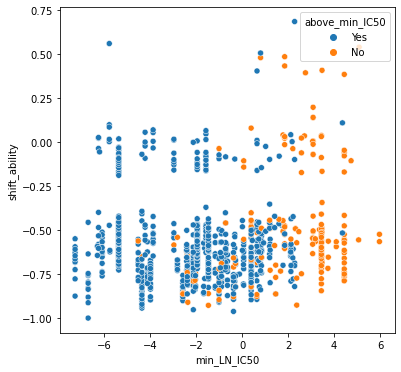

In [191]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='min_LN_IC50', y='shift_ability', hue='above_min_IC50',
                data=shift_ability_GDSC[shift_ability_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='max_LN_IC50', ylabel='shift_ability'>

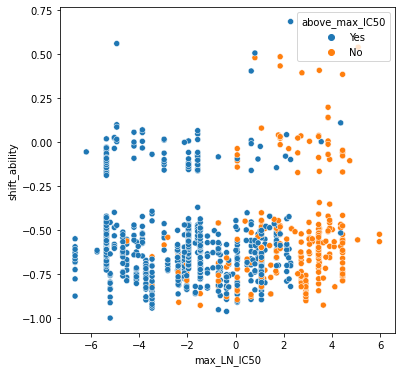

In [192]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='max_LN_IC50', y='shift_ability', hue='above_max_IC50',
                data=shift_ability_GDSC[shift_ability_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='min_LN_IC50', ylabel='NREC_profile'>

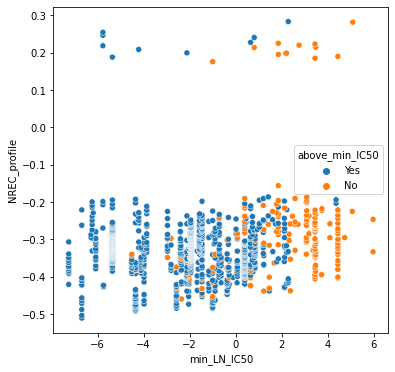

In [193]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='min_LN_IC50', y='NREC_profile', hue='above_min_IC50',
                data=shift_ability_GDSC[shift_ability_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='min_LN_IC50', ylabel='REC_profile'>

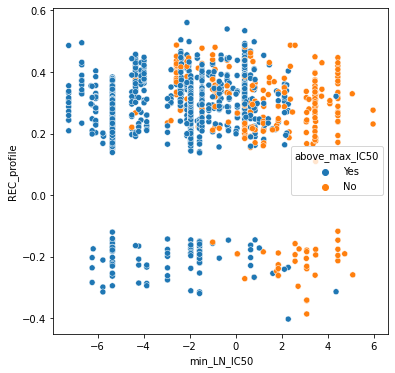

In [194]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='min_LN_IC50', y='REC_profile', hue='above_max_IC50',
                data=shift_ability_GDSC[shift_ability_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='max_LN_IC50', ylabel='NREC_profile'>

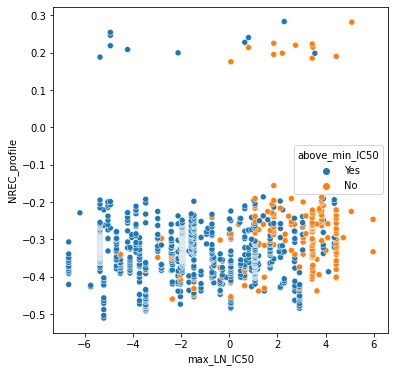

In [195]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='max_LN_IC50', y='NREC_profile', hue='above_min_IC50',
                data=shift_ability_GDSC[shift_ability_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='max_LN_IC50', ylabel='REC_profile'>

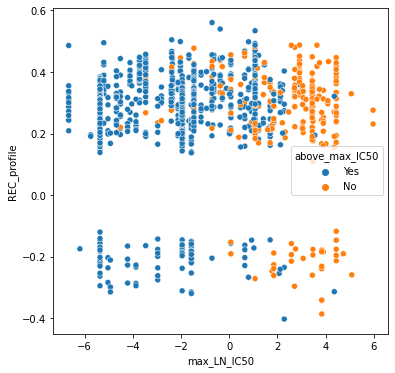

In [196]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='max_LN_IC50', y='REC_profile', hue='above_max_IC50',
                data=shift_ability_GDSC[shift_ability_GDSC['min_LN_IC50'] != 'not available'])

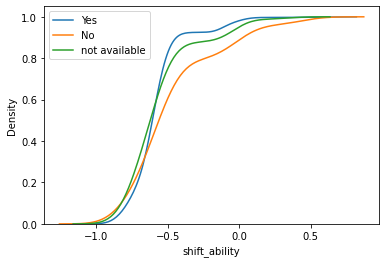

In [209]:
for k in shift_ability_GDSC['above_min_IC50'].unique():
    tmp_s = shift_ability_GDSC[shift_ability_GDSC['above_min_IC50'] == k]
    sns.kdeplot(x='shift_ability', data=tmp_s, cumulative=True, label=k)
plt.legend()

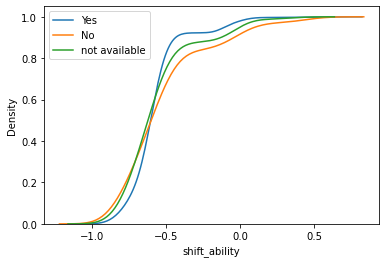

In [210]:
for k in shift_ability_GDSC['above_max_IC50'].unique():
    tmp_s = shift_ability_GDSC[shift_ability_GDSC['above_max_IC50'] == k]
    sns.kdeplot(x='shift_ability', data=tmp_s, cumulative=True, label=k)
plt.legend()

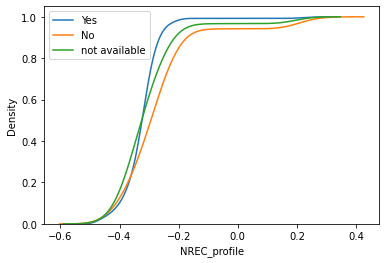

In [211]:
for k in shift_ability_GDSC['above_min_IC50'].unique():
    tmp_s = shift_ability_GDSC[shift_ability_GDSC['above_min_IC50'] == k]
    sns.kdeplot(x='NREC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

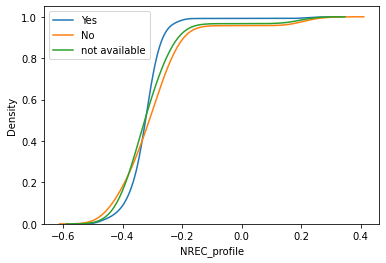

In [212]:
for k in shift_ability_GDSC['above_max_IC50'].unique():
    tmp_s = shift_ability_GDSC[shift_ability_GDSC['above_max_IC50'] == k]
    sns.kdeplot(x='NREC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

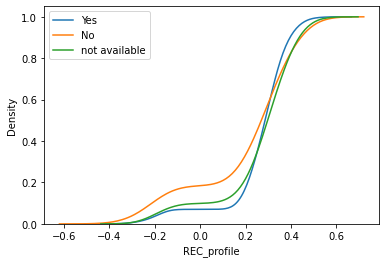

In [213]:
for k in shift_ability_GDSC['above_min_IC50'].unique():
    tmp_s = shift_ability_GDSC[shift_ability_GDSC['above_min_IC50'] == k]
    sns.kdeplot(x='REC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

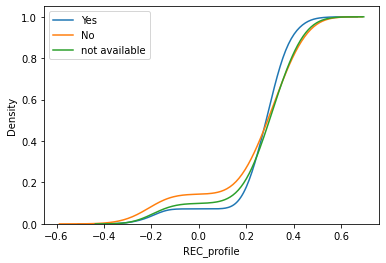

In [214]:
for k in shift_ability_GDSC['above_max_IC50'].unique():
    tmp_s = shift_ability_GDSC[shift_ability_GDSC['above_max_IC50'] == k]
    sns.kdeplot(x='REC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

## 1. shift ability versus IC50

<AxesSubplot:xlabel='above_min_IC50', ylabel='shift_ability'>

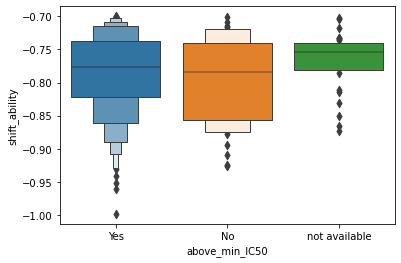

In [140]:
sns.boxenplot(x='above_min_IC50', y='shift_ability', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_max_IC50', ylabel='shift_ability'>

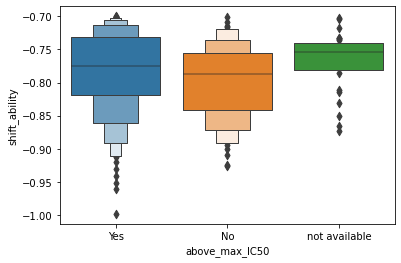

In [141]:
sns.boxenplot(x='above_max_IC50', y='shift_ability', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_min_IC50', ylabel='shift_ability'>

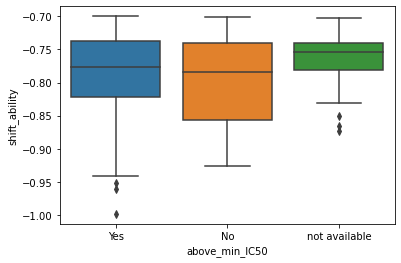

In [153]:
sns.boxplot(x='above_min_IC50', y='shift_ability', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_max_IC50', ylabel='shift_ability'>

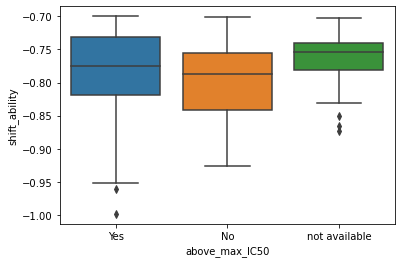

In [154]:
sns.boxplot(x='above_max_IC50', y='shift_ability', data=sig_shift_GDSC)

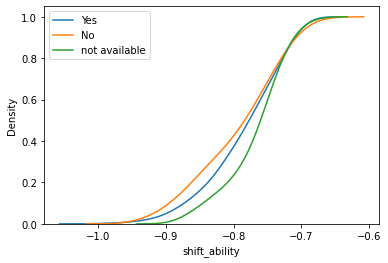

In [167]:
for k in sig_shift_GDSC['above_min_IC50'].unique():
    tmp_s = sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == k]
    sns.kdeplot(x='shift_ability', data=tmp_s, cumulative=True, label=k)
plt.legend()

In [171]:
stats.ks_2samp(sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'Yes']['shift_ability'],
               sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'No']['shift_ability'])

KstestResult(statistic=0.13904286770140428, pvalue=0.45351822439112555)

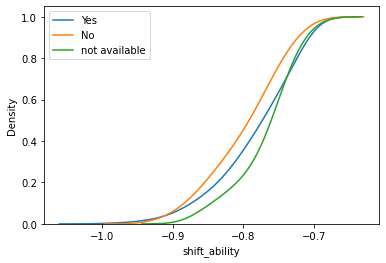

In [168]:
for k in sig_shift_GDSC['above_max_IC50'].unique():
    tmp_s = sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == k]
    sns.kdeplot(x='shift_ability', data=tmp_s, cumulative=True, label=k)
plt.legend()

In [172]:
stats.ks_2samp(sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'Yes']['shift_ability'],
               sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'No']['shift_ability'])

KstestResult(statistic=0.1780625143645139, pvalue=0.04467649506844462)

<AxesSubplot:xlabel='min_LN_IC50', ylabel='shift_ability'>

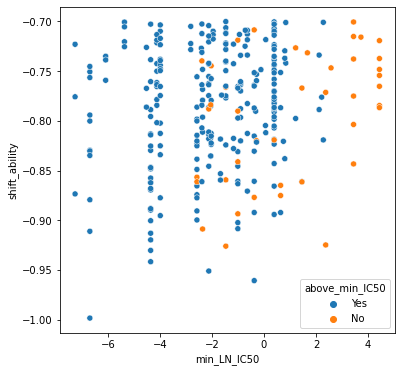

In [201]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='min_LN_IC50', y='shift_ability', hue='above_min_IC50',
                data=sig_shift_GDSC[sig_shift_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='max_LN_IC50', ylabel='shift_ability'>

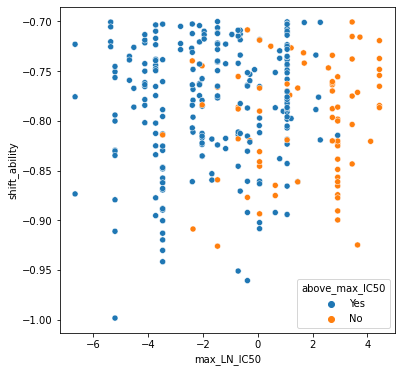

In [202]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='max_LN_IC50', y='shift_ability', hue='above_max_IC50',
                data=sig_shift_GDSC[sig_shift_GDSC['max_LN_IC50'] != 'not available'])

## 2. NREC versus IC50

<AxesSubplot:xlabel='above_min_IC50', ylabel='NREC_profile'>

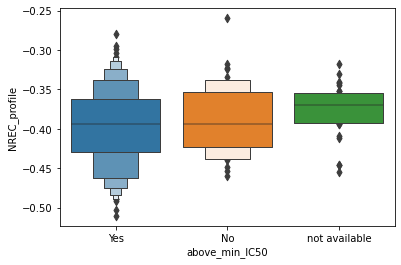

In [142]:
sns.boxenplot(x='above_min_IC50', y='NREC_profile', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_max_IC50', ylabel='NREC_profile'>

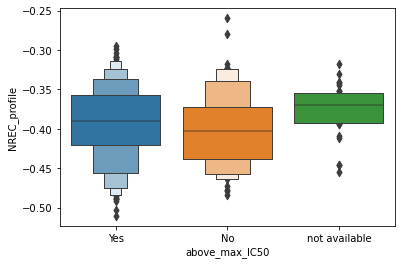

In [143]:
sns.boxenplot(x='above_max_IC50', y='NREC_profile', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_min_IC50', ylabel='NREC_profile'>

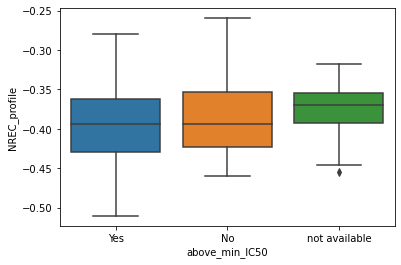

In [149]:
sns.boxplot(x='above_min_IC50', y='NREC_profile', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_max_IC50', ylabel='NREC_profile'>

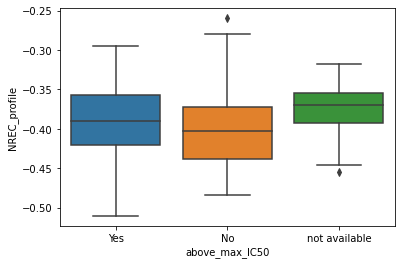

In [150]:
sns.boxplot(x='above_max_IC50', y='NREC_profile', data=sig_shift_GDSC)

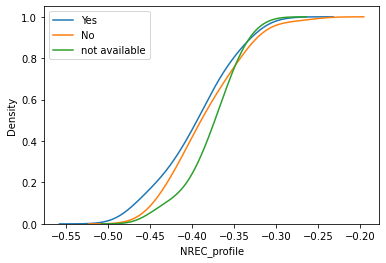

In [165]:
for k in sig_shift_GDSC['above_min_IC50'].unique():
    tmp_s = sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == k]
    sns.kdeplot(x='NREC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

In [175]:
stats.ks_2samp(sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'Yes']['NREC_profile'],
               sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'No']['NREC_profile'])

KstestResult(statistic=0.13303769401330376, pvalue=0.508886551330122)

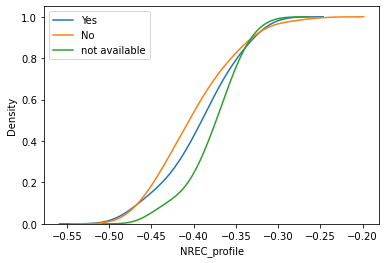

In [166]:
for k in sig_shift_GDSC['above_max_IC50'].unique():
    tmp_s = sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == k]
    sns.kdeplot(x='NREC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

In [174]:
stats.ks_2samp(sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'Yes']['NREC_profile'],
               sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'No']['NREC_profile'])

KstestResult(statistic=0.17725810158584235, pvalue=0.0479312935524302)

<AxesSubplot:xlabel='min_LN_IC50', ylabel='NREC_profile'>

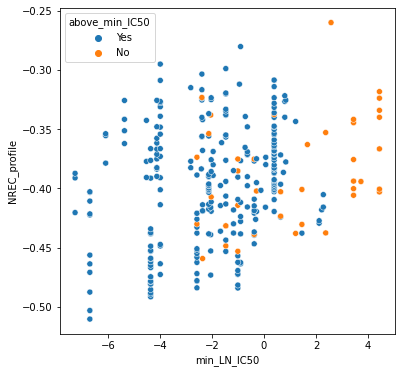

In [200]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='min_LN_IC50', y='NREC_profile', hue='above_min_IC50',
                data=sig_shift_GDSC[sig_shift_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='max_LN_IC50', ylabel='NREC_profile'>

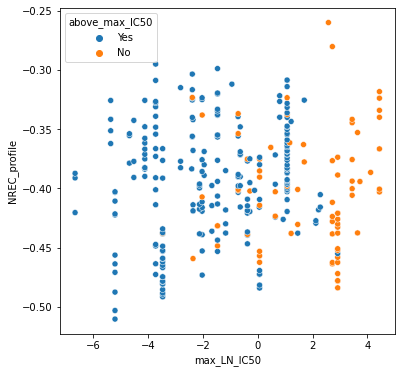

In [203]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='max_LN_IC50', y='NREC_profile', hue='above_max_IC50',
                data=sig_shift_GDSC[sig_shift_GDSC['max_LN_IC50'] != 'not available'])

## 3. REC versus IC50

<AxesSubplot:xlabel='above_min_IC50', ylabel='REC_profile'>

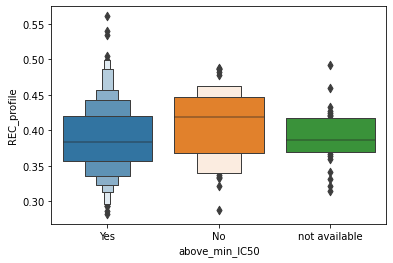

In [144]:
sns.boxenplot(x='above_min_IC50', y='REC_profile', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_max_IC50', ylabel='REC_profile'>

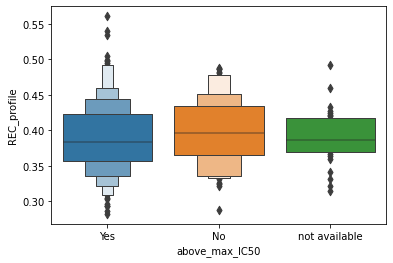

In [145]:
sns.boxenplot(x='above_max_IC50', y='REC_profile', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_min_IC50', ylabel='REC_profile'>

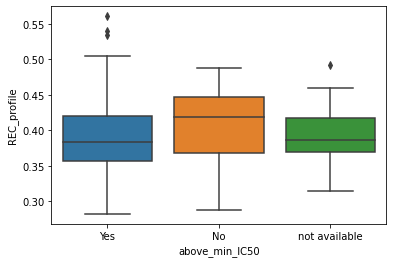

In [147]:
sns.boxplot(x='above_min_IC50', y='REC_profile', data=sig_shift_GDSC)

<AxesSubplot:xlabel='above_max_IC50', ylabel='REC_profile'>

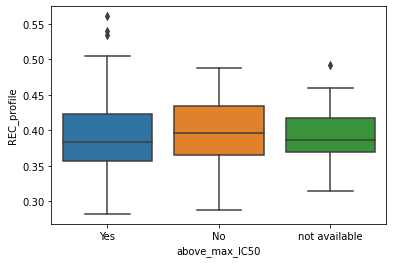

In [148]:
sns.boxplot(x='above_max_IC50', y='REC_profile', data=sig_shift_GDSC)

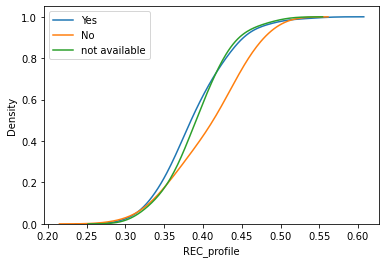

In [169]:
for k in sig_shift_GDSC['above_min_IC50'].unique():
    tmp_s = sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == k]
    sns.kdeplot(x='REC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

In [176]:
stats.ks_2samp(sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'Yes']['REC_profile'],
               sig_shift_GDSC[sig_shift_GDSC['above_min_IC50'] == 'No']['REC_profile'])

KstestResult(statistic=0.2958240946045824, pvalue=0.002996074919823122)

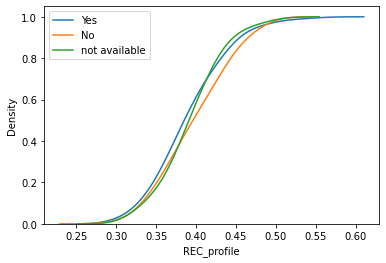

In [170]:
for k in sig_shift_GDSC['above_max_IC50'].unique():
    tmp_s = sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == k]
    sns.kdeplot(x='REC_profile', data=tmp_s, cumulative=True, label=k)
plt.legend()

In [177]:
stats.ks_2samp(sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'Yes']['REC_profile'],
               sig_shift_GDSC[sig_shift_GDSC['above_max_IC50'] == 'No']['REC_profile'])

KstestResult(statistic=0.1327855665364284, pvalue=0.24335593107176023)

<AxesSubplot:xlabel='min_LN_IC50', ylabel='REC_profile'>

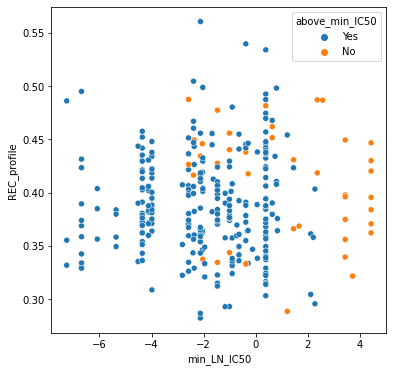

In [204]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='min_LN_IC50', y='REC_profile', hue='above_min_IC50',
                data=sig_shift_GDSC[sig_shift_GDSC['min_LN_IC50'] != 'not available'])

<AxesSubplot:xlabel='max_LN_IC50', ylabel='REC_profile'>

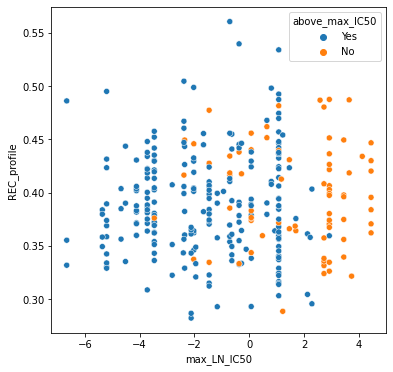

In [205]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='max_LN_IC50', y='REC_profile', hue='above_max_IC50',
                data=sig_shift_GDSC[sig_shift_GDSC['max_LN_IC50'] != 'not available'])

# SK-MEL-5

In [230]:
shift_ability_SKM5 = shift_ability[shift_ability['cell_line'] == 'SKMEL5']
shift_ability_SKM5 = shift_ability_SKM5[shift_ability_SKM5['cmap_name'].isin(cmap_gdsc_skcm.index)]

In [231]:
# add IC50, if multiple, take the minimal IC50 and maximal IC50
shift_ability_SKM5['min_LN_IC50'] = 'not available'
shift_ability_SKM5['max_LN_IC50'] = 'not available'

for q in shift_ability_SKM5.index:
    tmp_drug = shift_ability_SKM5.loc[q, 'cmap_name']
    tmp_gdsc_drug = cmap_gdsc_skcm.loc[tmp_drug, 'GDSC_name']
    tmp_ic50 = []
    if cmap_gdsc_skcm.loc[tmp_drug, 'GDSC_V1'] == 'Yes':
        tmp_ic50.extend(list(gdsc_subset1_SKM5[gdsc_subset1_SKM5['DRUG_NAME'] == tmp_gdsc_drug]['LN_IC50']))
    if cmap_gdsc_skcm.loc[tmp_drug, 'GDSC_V2'] == 'Yes':
        tmp_ic50.extend(list(gdsc_subset2_SKM5[gdsc_subset2_SKM5['DRUG_NAME'] == tmp_gdsc_drug]['LN_IC50']))
    if len(tmp_ic50) > 0:
        shift_ability_SKM5.at[q, 'min_LN_IC50'] = min(tmp_ic50)
        shift_ability_SKM5.at[q, 'max_LN_IC50'] = max(tmp_ic50)


In [232]:
shift_ability_SKM5

,NREC_profile,REC_profile,cmap_name,shift_ability,dose,time,cell_line,dose_cat,dose_color,LN_dose,min_LN_IC50,max_LN_IC50
EMU001_SKMEL5_24H:N13,-0.468547,0.384182,parthenolide,-0.852729,10.000,24.0,SKMEL5,medium,moccasin,2.302585,not available,not available
AICHI002_SKMEL5_24H:M10,-0.461942,0.431739,dinaciclib,-0.893680,0.125,24.0,SKMEL5,low,royalblue,-2.079442,-1.7284,-1.7284
EMU001_SKMEL5_24H:F09,-0.456849,0.419450,doxorubicin,-0.876299,0.660,24.0,SKMEL5,low,royalblue,-0.415515,-1.67159,-1.04442
EMU001_SKMEL5_24H:O02,-0.455086,0.243111,vorinostat,-0.698197,2.500,24.0,SKMEL5,low,royalblue,0.916291,-0.256069,-0.256069
AICHI002_SKMEL5_24H:G14,-0.454505,0.344559,vorinostat,-0.799064,2.500,24.0,SKMEL5,low,royalblue,0.916291,-0.256069,-0.256069
...,...,...,...,...,...,...,...,...,...,...,...,...
AICHI001_SKMEL5_24H:C01,-0.227416,-0.230241,tozasertib,0.002826,10.000,24.0,SKMEL5,medium,moccasin,2.302585,not available,not available
EMU001_SKMEL5_24H:K15,0.212878,-0.196316,paclitaxel,0.409194,0.660,24.0,SKMEL5,low,royalblue,-0.415515,not available,not available
AICHI002_SKMEL5_24H:L07,0.237795,0.258916,linifanib,-0.021121,10.000,24.0,SKMEL5,medium,moccasin,2.302585,3.27693,3.27693
AICHI001_SKMEL5_24H:P04,0.248377,-0.180624,A-443654,0.429001,0.125,24.0,SKMEL5,low,royalblue,-2.079442,not available,not available


In [233]:
shift_ability_SKM5['above_min_IC50'] = 'not available'
shift_ability_SKM5['above_max_IC50'] = 'not available'

for q in shift_ability_SKM5.index:
    if shift_ability_SKM5.loc[q, 'min_LN_IC50'] != 'not available':
        if shift_ability_SKM5.loc[q, 'LN_dose'] <= shift_ability_SKM5.loc[q, 'min_LN_IC50']:
            shift_ability_SKM5.at[q, 'above_min_IC50'] = 'No'
        else:
            shift_ability_SKM5.at[q, 'above_min_IC50'] = 'Yes'
    if shift_ability_SKM5.loc[q, 'max_LN_IC50'] != 'not available':
        if shift_ability_SKM5.loc[q, 'LN_dose'] <= shift_ability_SKM5.loc[q, 'max_LN_IC50']:
            shift_ability_SKM5.at[q, 'above_max_IC50'] = 'No'
        else:
            shift_ability_SKM5.at[q, 'above_max_IC50'] = 'Yes'

In [236]:
sig_shift_SKM5 = shift_ability_SKM5[shift_ability_SKM5['shift_ability'] <= -.7]

In [235]:
shift_ability_SKM5['above_min_IC50'].value_counts()

No               32
not available    24
Yes              21
Name: above_min_IC50, dtype: int64

In [237]:
sig_shift_SKM5['above_min_IC50'].value_counts()

No               21
Yes               9
not available     5
Name: above_min_IC50, dtype: int64

In [238]:
sig_shift_SKM5['above_max_IC50'].value_counts()

No               23
Yes               7
not available     5
Name: above_max_IC50, dtype: int64

## 1. REC vs. IC50

<AxesSubplot:xlabel='above_min_IC50', ylabel='REC_profile'>

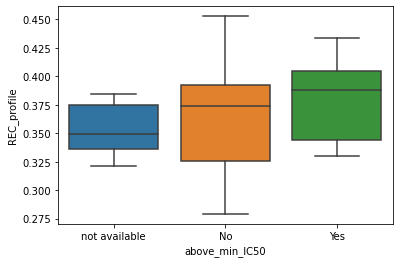

In [240]:
sns.boxplot(x='above_min_IC50', y='REC_profile', data=sig_shift_SKM5)

<AxesSubplot:xlabel='above_min_IC50', ylabel='REC_profile'>

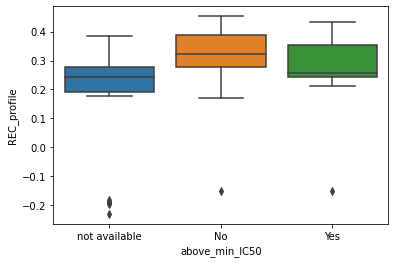

In [242]:
sns.boxplot(x='above_min_IC50', y='REC_profile', data=shift_ability_SKM5)

<AxesSubplot:xlabel='above_max_IC50', ylabel='REC_profile'>

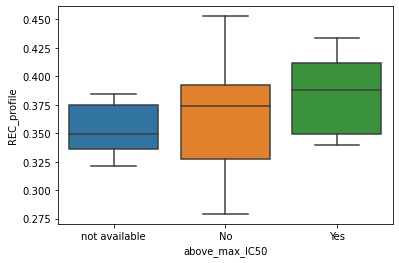

In [243]:
sns.boxplot(x='above_max_IC50', y='REC_profile', data=sig_shift_SKM5)

<AxesSubplot:xlabel='above_max_IC50', ylabel='REC_profile'>

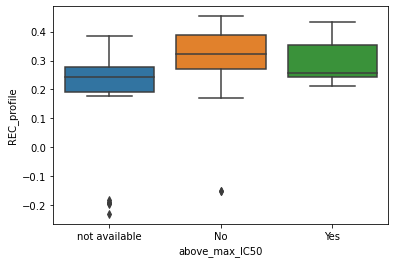

In [244]:
sns.boxplot(x='above_max_IC50', y='REC_profile', data=shift_ability_SKM5)

## 2. NREC vs. IC50

<AxesSubplot:xlabel='above_min_IC50', ylabel='NREC_profile'>

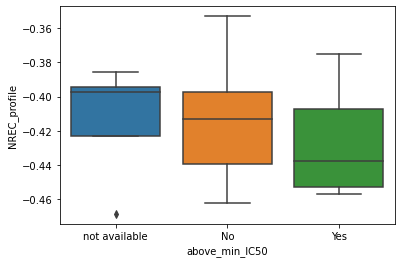

In [245]:
sns.boxplot(x='above_min_IC50', y='NREC_profile', data=sig_shift_SKM5)

<AxesSubplot:xlabel='above_min_IC50', ylabel='NREC_profile'>

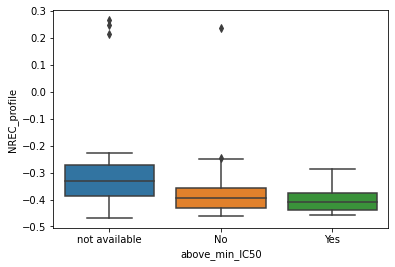

In [246]:
sns.boxplot(x='above_min_IC50', y='NREC_profile', data=shift_ability_SKM5)

<AxesSubplot:xlabel='above_max_IC50', ylabel='NREC_profile'>

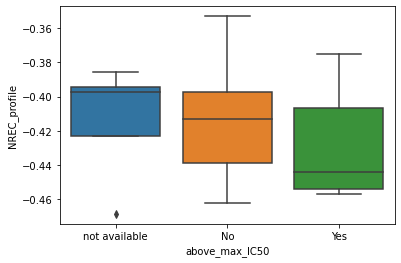

In [247]:
sns.boxplot(x='above_max_IC50', y='NREC_profile', data=sig_shift_SKM5)

<AxesSubplot:xlabel='above_max_IC50', ylabel='NREC_profile'>

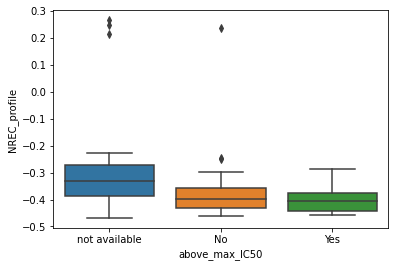

In [248]:
sns.boxplot(x='above_max_IC50', y='NREC_profile', data=shift_ability_SKM5)

## 3. shift ability vs. IC50

<AxesSubplot:xlabel='above_min_IC50', ylabel='shift_ability'>

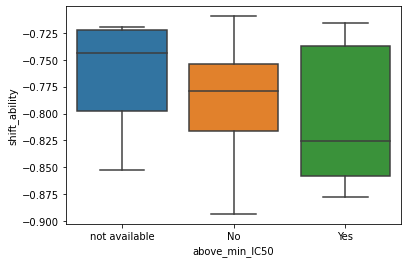

In [249]:
sns.boxplot(x='above_min_IC50', y='shift_ability', data=sig_shift_SKM5)

<AxesSubplot:xlabel='above_min_IC50', ylabel='shift_ability'>

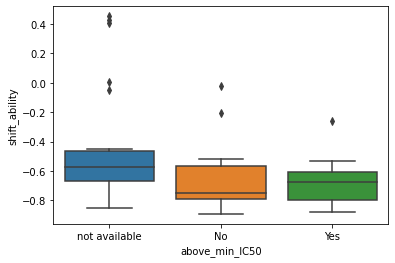

In [250]:
sns.boxplot(x='above_min_IC50', y='shift_ability', data=shift_ability_SKM5)

<AxesSubplot:xlabel='above_max_IC50', ylabel='shift_ability'>

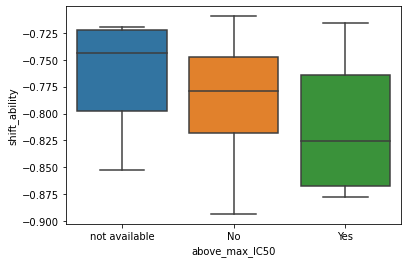

In [252]:
sns.boxplot(x='above_max_IC50', y='shift_ability', data=sig_shift_SKM5)

<AxesSubplot:xlabel='above_max_IC50', ylabel='shift_ability'>

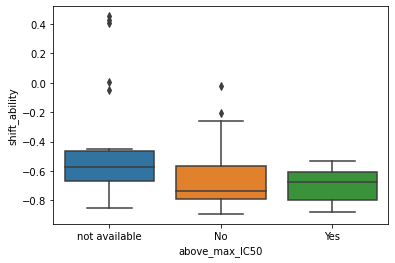

In [251]:
sns.boxplot(x='above_max_IC50', y='shift_ability', data=shift_ability_SKM5)